## SQLite database Analysis using SQLAlchemy & Pandas
This notebook contains the procress of setting up an SQLAlchemy connection to the sqlite database file found in the repo. This database contains weather station data for weather stations found in Hawaii. Analysis was done to determine precipitation found during a given range of time, what the most active weather station is, and what the temperature values and statistics for that weather station are.

In [1]:
## Import Dependancies

## Matplotlib visual styles, and 
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

## SQLAlchemy imports
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

## Additional Imports
import numpy as np
import pandas as pd
import datetime as dt

## SQLAlchemy ORM setup

In [2]:
## Create engine and dialect for sqlite database.
engine = create_engine("sqlite:///resources/hawaii.sqlite")

## Using automap_base, create a reflection using the existing database schema from
Base = automap_base()

## reflect the tables from the engine using the automap_base setup earlier.
Base.prepare(engine, reflect = True)

## View what classes were found. These are the tables in the database.
Base.classes.keys()

['measurement', 'station']

In [3]:
## Assign references to the tables for future querying.
measurements = Base.classes.measurement

stations = Base.classes.station

In [4]:
## Initiate the session 
session = Session(engine)

In [5]:
## Observe the tables through a query. This will provide information needed for specified queries.
measure_rows =  session.query(measurements).first()

measure_rows.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x167fea87f40>,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [6]:
station_rows =  session.query(stations).first()
station_rows.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x167fea87730>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397',
 'id': 1,
 'latitude': 21.2716,
 'elevation': 3.0}

## Analysis 1: Date Specific Precipitation
This section of analysis will build information in order to query the database based on the most recent date in found in the databse. From this date, this section analyzes the past one year of precipitation data in the database.

In [7]:
## Query to find the most recent date. The resulting date is then cleaned for calculation.
recent_date = session.query(measurements.date).\
order_by(measurements.date.desc()).first()

date_str = str(recent_date)

start_date = date_str.translate({ord(n): None for n in "(,)''"})

In [8]:
# Calculate the date one year from the most recent date in database. 
start =  dt.datetime.strptime(start_date,'%Y-%m-%d')

year = dt.timedelta(days=365)

## Since we know the timedelta is 365, we can use that to find the missing expression, the delta2.
## (Delta1(start) - Delta2(end) = Timedelta(365)). 
end = start - year

end = dt.datetime.strftime(end,'%Y-%m-%d')

print(f'One year from {start_date} is {end}')

One year from 2017-08-23 is 2016-08-23


In [9]:
## Query the date and prcp results within the date range. This can be accomplished with one query.
## But at my current skill level/knowledge doing two queries made creating a DataFrame more convenient.  
date_results = session.query(measurements.date).\
filter(func.strftime("%Y-%m-%d",measurements.date) >= end).all()

prcp_results = session.query(measurements.prcp).\
filter(func.strftime("%Y-%m-%d",measurements.date) >= end).all()

In [10]:
## Dataframe creation from the results, sorting and using the date as an index.
percip_df = pd.DataFrame({
    'date':date_results,
    'percipitation':prcp_results
      })

## Cleaning the outputed queries as well in anticipation for plotting.
percip_df['date'] = percip_df['date'].astype(str)
percip_df['date'] = percip_df['date'].str.translate({ord(n): None for n in "(,)''"})
percip_df['date'] = pd.to_datetime(percip_df['date'])

## Cleaning the outputed queries as well in anticipation for plotting.
percip_df['percipitation'] = percip_df['percipitation'].astype(str)
percip_df['percipitation'] = percip_df['percipitation'].str.translate({ord(n): None for n in "(,)''"})
percip_df['percipitation'] = percip_df['percipitation'].replace('None',0)
percip_df['percipitation'] = percip_df['percipitation'].astype(float)
          
percip_df = percip_df.set_index('date')
percip_df = percip_df.sort_index()
percip_df

,percipitation
date,
2016-08-23,0.00
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


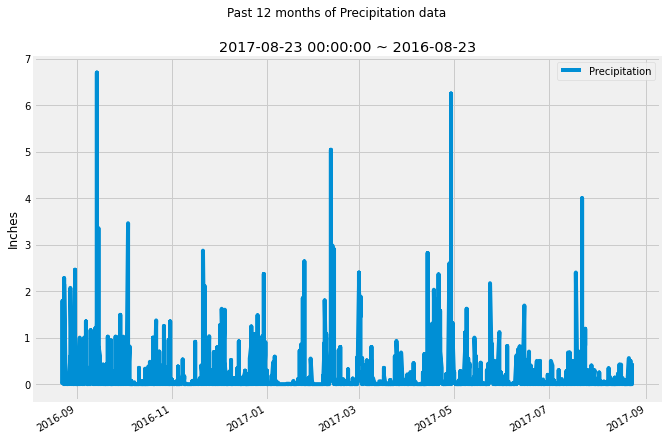

In [11]:
## Plot the DataFrame to visualize precipitation over time for the past year from the most recent database date.

plt.figure(figsize=(10,7))
plt.plot(percip_df)
plt.gcf().autofmt_xdate()
plt.ylabel('Inches')
plt.legend(['Precipitation'])
plt.suptitle("Past 12 months of Precipitation data")
plt.title(f"{start} ~ {end}")
plt.show()

In [12]:
## View summary statistics
percip_df.describe()

,percipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [13]:
percip_df.agg(['mean','median','var','std','sem'])

,percipitation
mean,0.160664
median,0.010000
var,0.195423
std,0.442067
sem,0.009361


## Analysis 2: Station-wise data
This section of analysis looks at station specific temperature data. The most active station is queried, and that station is used as the basis for data analysis.

In [14]:
## Query that finds how many unique stations
unique_station = session.query(func.count(stations.station)).all()

## Query that finds EVERY report of a stations data and counts
every_station = session.query(func.count(measurements.station)).all()

## If Else statement that checks for null datapoints in the databases precipitation column. As the is_not function
## returns a bool dependant on if it found a null value, if it is True we can say we have an accurate count that does not
## contain any stations that have no data entry. Visually, you can see what this accomplishes from the print statement below.

null_datapoint = session.query(func.count(measurements.station).\
                               filter(measurements.prcp >= 0).\
                               is_not(None)).all()
if null_datapoint == [(True,)]:
    print('There are no null values')
    notNull_datapoint = session.query(func.count(measurements.station).\
                                      filter(measurements.prcp >= 0)).all()
else:
    print('There are null values')

There are no null values


In [15]:
## As a result of the If Else statement above, which contains a query that specifically looks for stations that reported a
## precipitaiton of 0 or greater. As negative precipitation can only be observed as a timewise average, filtering in this way
## accomplishes the goal of not seeing any null datapoints. 

print(f'The number of unique station IDs is {unique_station[0]}')
print(f'The number of station datapoints in the dataset is {every_station[0]}')
print(f'The number of datapoints not null is {notNull_datapoint[0]}')

The number of unique station IDs is (9,)
The number of station datapoints in the dataset is (19550,)
The number of datapoints not null is (18103,)


In [16]:
## Query that finds the most active station
session.query(measurements.station, func.count(measurements.id)).\
    group_by(measurements.station).all()

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [17]:
## Query that is sorted and assigned so it can be referenced. 
station_counts = session.query(measurements.station, func.count(measurements.id)).\
    group_by(measurements.station).\
    order_by(func.count(measurements.prcp).desc()).all()
station_counts

[('USC00519281', 2772),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
## Clean the most active staitons data in anticipation for dynamic query.
## Dynamic query meaning that the station is not input statically, and can be updated with new data.

most_active = str(station_counts[0])
active_station = most_active.split(',')[0]
active_station = active_station.translate({ord(n): None for n in "(,)''"})
active_station

'USC00519281'

In [19]:
## Query for the average temperature results from the most active station.
temp_results_avg = session.query(measurements.station,func.avg(measurements.tobs)).\
    filter(measurements.station == active_station).all()
temp_results_avg

## Query for the max temperature results from the most active station.
temp_results_max = session.query(measurements.station,func.max(measurements.tobs)).\
    filter(measurements.station == active_station).all()
temp_results_max

## Query for the min temperature results from the most active station.
temp_results_min = session.query(measurements.station,func.min(measurements.tobs)).\
    filter(measurements.station == active_station).all()
temp_results_min

print(f'The max temperature from station {active_station} is {temp_results_max} ')
print(f'The max temperature from station {active_station} is {temp_results_min} ')
print(f'The max temperature from station {active_station} is {temp_results_avg} ')

The max temperature from station USC00519281 is [('USC00519281', 85.0)] 
The max temperature from station USC00519281 is [('USC00519281', 54.0)] 
The max temperature from station USC00519281 is [('USC00519281', 71.66378066378067)] 


In [20]:
## Query for the past year of data available for the most active station
temp_results = session.query(measurements.tobs).\
    filter(func.strftime("%Y-%m-%d",measurements.date) >= end).\
    filter(measurements.station == active_station).all()
## Check to see if length exceeds 365. Since each day has at most 1 recording, this value should not exceed 365. 
len(temp_results)

352

In [21]:
## Create DataFrame for plot. Clean the data in anticipation for plotting.
temp_df = pd.DataFrame({
    'temperature':temp_results
      }) 

temp_df['temperature'] = temp_df['temperature'].astype(str)
temp_df['temperature'] = temp_df['temperature'].str.translate({ord(n): None for n in "(,)''"})
temp_df['temperature'] = temp_df['temperature'].replace('None',0)
temp_df['temperature'] = temp_df['temperature'].astype(float)
          
temp_df

,temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


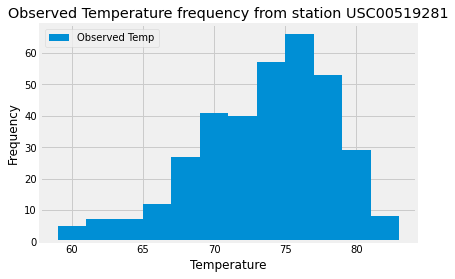

In [22]:
## Plot a histogram to show temperature frequency observed in this station.

plt.hist(x = temp_df,bins=12)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.legend(['Observed Temp'])
plt.title(f'Observed Temperature frequency from station {active_station}')
plt.show()

In [23]:
## Once all Queries have been made, close the session. 
session.close()